# **Introduction**

In this project we develop a Convolution Neural Network Architecture to classify handwritten digits. We used the popular MNIST data set in already integrated in Keras. Finally we convert our tenssoflow model into a TensorflowLite file, which we finally deployed in an android environment.

# Problem Statement and Background
Hand writing recognition has been in existence since the 1980s.It has been used widely by researchers as experiments for theories of machine learning algorithms. In the field of application, it has great importance and use such as – online handwriting recognition on computer tablets, recognize zip codes on mail for postal mail sorting, processing bank check amounts, numeric entries in forms filled up by hand (for example ‐ tax forms) and so on. There are different challenges faced while attempting to solve this problem. The handwritten digits are not always
of the same size, thickness, or orientation and position relative to the margins. Our goal is to improve predictive power by implementing a pattern classification method (CNN) to recognize the handwritten digits provided in the MINIST
data set of images of hand written digits (0‐9) and also develop and android app. We seek to improve performance of existing CNNs as well as apps through data augmentation, data normalization, hyperparameter tuning and regularization techniques. 

# Methodology
We provide an end-to-end approach to solving the problem of handwritten digit recognition. The folowwing steps are adopted:
1. Import and download necessary dependencies
2. Download and visulize MNIST data
3. Define CNN model architecture and train model on input imgaes
4. Model Evaluation on test set
5. Conversion of Keras/Tensorflow  model to Tensorflow Lite
6. Perform Quantization and evaluate performance of Quantized model.
7. Doanload Tensorflow Lite model for deployment on Android.

## Import and download dependencies

In [0]:
#Importing helper libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

print(tf.__version__)

2.2.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Download and display sample digits in data set
The MNIST dataset consist of  60,000 training images and 10,000 testing images of handwritten digits. We will use the dataset to train our digit classification model.

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit from 0 to 9, and a label identifying which digit is in the image.
![MNIST sample](https://github.com/khanhlvg/DigitClassifier/raw/master/images/mnist.png)

In [0]:
# Downloading and splitting data into training and test set
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
test_images.shape

(10000, 28, 28)

Text(0.5, 1.0, 'Distribution of Class Labels')

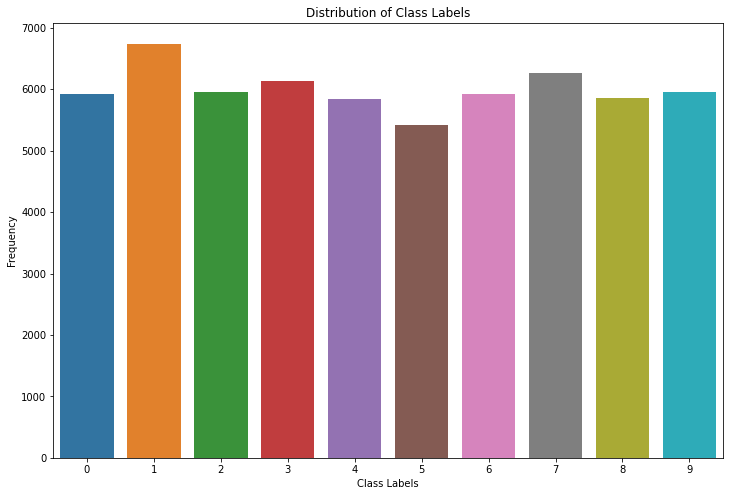

In [0]:
plt.figure(figsize=(12,8))
sns.countplot(train_labels)
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Class Labels")

In [0]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0


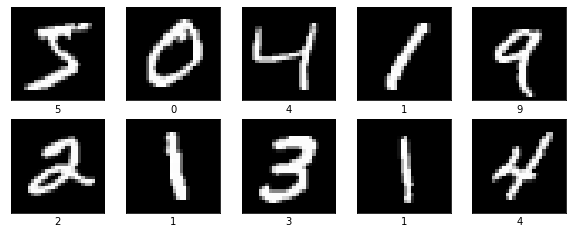

In [0]:
# Show the first 10 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

## Train a TensorFlow model to classify digit images

We define a CNN model architecture using Keras and Tensorflow

In [0]:
from keras.utils.np_utils import to_categorical
x_train,y_train,x_test,y_test=train_images,train_labels,test_images,test_labels
#x_train,x_test=np.array(x_train, np.float32),np.array(x_test,np.float32)
y_train=to_categorical(y_train,10)
y_test=to_categorical(y_test,10)
x_train=np.expand_dims(x_train,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)

In [0]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [0]:
#squeeze and excite function to assignment weights to channels
def sq_ex_block(filters,input):
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Reshape((1, filters))(se) 
    se = tf.keras.layers.Dense(filters//32, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    se = tf.keras.layers.multiply([input, se])
    return se


In [0]:
from keras.preprocessing.image import ImageDataGenerator
# data augmentation to prevent overfitting
datagen=ImageDataGenerator(featurewise_center=False, 
                           samplewise_center=False, 
                           featurewise_std_normalization=False, 
                           samplewise_std_normalization=False, 
                           zca_whitening=False, 
                           rotation_range=8, 
                           width_shift_range=0.1, 
                           height_shift_range=0.1, 
                           brightness_range=None,  
                           zoom_range=0.1, 
                           channel_shift_range=0.0, 
                           fill_mode='nearest', cval=0.0, 
                           horizontal_flip=False, 
                           vertical_flip=False 
                           )
datagen.fit(x_train)
datagen2=ImageDataGenerator()
datagen2.fit(x_test)

In [0]:
# Define the model architecture
def conv_model():
  m = tf.keras.Input(shape=x_train.shape[1:])
  x = tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),padding='Same',activation='relu')(m)
 # x = tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),padding='Same',activation='relu')(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  x = tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),padding='Same',activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = sq_ex_block(64,x)

  x = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
  x = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = sq_ex_block(64,x)
  x = tf.keras.layers.AveragePooling2D(2)(x)
  x = tf.keras.layers.concatenate([tf.keras.layers.GlobalMaxPooling2D()(x),
                                         tf.keras.layers.GlobalAveragePooling2D()(x)])
  x = tf.keras.layers.Dense(64,activation="relu")(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(10,activation='softmax')(x)
  
  return tf.keras.Model(m,x)






In [0]:
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

#define optimizer
optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [0]:
model=conv_model()

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 28, 28, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   102464      dropout[0][0]                    
______________________________________________________________________________________________

In [0]:
batch_size=64
# Define how to train the model
model=conv_model()
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss="categorical_crossentropy",
              metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size,shuffle=True),
                    steps_per_epoch=len(x_train) / batch_size, epochs=12,verbose=0)

# Train the digit classification model
#model.fit(train_images, train_labels, epochs=5)

Let's take a closer look at our model structure.

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 64)   1664        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 28, 28, 64)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 64)   102464      dropout_3[0][0]                  
____________________________________________________________________________________________

## Model Evaluation on Test set

In [0]:
# Evaluate the model using all images in the test dataset.
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.0226 - accuracy: 0.9934
Test accuracy: 0.993399977684021


Hurray!! Our model achieves an accuracy of 99%. Lets visualize the results to understand images that were inaccurately classified.

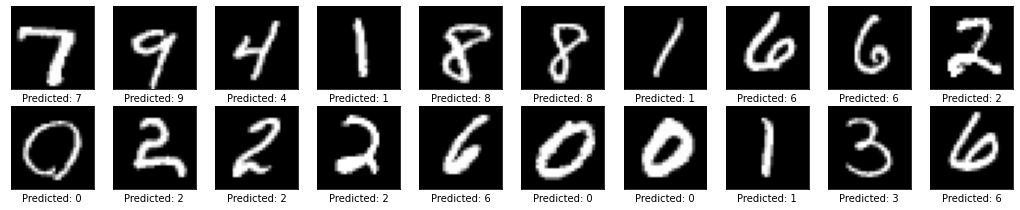

In [0]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

#largest probability
prediction_digits = np.argmax(predictions, axis=1)

#results for 20 images
plt.figure(figsize=(18, 18))
for i in range(20):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

## Convert the Keras model to TensorFlow Lite

Now as we have trained the digit classifer model, we will convert it to TensorFlow Lite format for mobile deployment.

In [0]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 886KBs.


**Quantization of model to reduce precision while ensuring it runs on android environment**

In [0]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 233KBs,
which is about 26% of the float model size.


## Evaluate the TensorFlow Lite model after quantization

In [0]:
# A function to evaluate performance of tensorflow lite model after quantization
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in x_test:
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference
    interpreter.invoke()

    # finding digits with highest probability
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index].any() == y_test[index].any():
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

#checking accuracy of tensorflow model
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

#Accuracy of quantized model
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))


Float model accuracy = 0.9024
Quantized model accuracy = 0.9024
Accuracy drop = 0.0000


## Download the TensorFlow Lite model


In [0]:
#model file for app
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')



References:
1. Matuzas, “MNIST classifier with average 0.17% error,” 2019. [Online]. Available: https://github.com/Matuzas77/MNIST-0.17.

2. https://www.kaggle.com/panyidoho/digit-j

3. https://codelabs.developers.google.com/codelabs/digit-classifier-tflite/#1